In [140]:
import pytorch_lightning as pl
from matplotlib import pyplot as plt
import seaborn as sns
from cca_zoo.deepmodels import (
    DCCA,
    #DCCA_NOI,
    DCCA_SDL,
    #BarlowTwins,
    get_dataloaders,
    
)
from cca_zoo.deepmodels.utils import architectures, objectives
from cca_zoo.plotting import pairplot_label
from cca_zoo.data import CCA_Dataset
from cca_zoo.models import CCA
import torch.optim as optim
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
import os
from scipy.spatial import distance
from scipy.stats import pearsonr
from scipy.stats import fisher_exact
from scipy.stats.contingency import crosstab
from scipy.stats import hypergeom
import random
import pandas as pd
import numpy as np
import pickle
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger


os.chdir('../raw_data')


#### Functions to load and or write to pickle files

In [3]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        
    

In [9]:
# load df with all info
path = './df_classes_max3_embeddings.pickle'
df_all = Files(path).load_pickle()#[:2000] #just a subset for scripting
df_all.shape

(41447, 8)

In [4]:
class DeepCCA:
    def __init__(self, df_all,batch_size = 700,num_workers = 6,\
                latent_dims=25, epochs=300, lr=0.001):
        
        self.df_all = df_all
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.v1='ms2ds'
        self.v2 = 'mol2vec'
        
        self.epochs = epochs
        self.sdl_lr = 0.025118864315095822#0.01#lr (picked after running lr_finder)
        self.dcca_lr = 5.623413251903491e-08 #lr
        self.latent_dims=latent_dims
        self.optim = 'sgd'
        self.objective = objectives.CCA
        self.layer_size = (500,300,300)
        
        
    def split_data(self,test_size=0.2,\
                   random_state=None,stratify=None): # thinking of removing this one
        
        if random_state != None and stratify == None:
            train_df, test_df = \
            train_test_split(self.df_all, test_size=test_size, random_state=random_state)
        
        elif random_state == None and stratify != None:
            train_df, test_df = \
            train_test_split(self.df_all, test_size=test_size,stratify=self.df_all[stratify])
        else:
            train_df, test_df = \
            train_test_split(self.df_all, test_size=test_size, random_state=42)
        
        return train_df, test_df 
    
    def gen_views(self,v1='ms2ds',v2='mol2vec'):
        
        #split test, train
        train_df, test_df= self.split_data(test_size=0.2,random_state=42)
        
        #Split train dataset into train and validation set
        train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)
        
        
        #extract the 2 view, v1 == spectra embeddings, v2==structure embeddings
        v1_train, v1_test = np.array([x for x in train_df[v1]]), np.array([x for x in test_df[v1]])
        v2_train, v2_test = np.array([x for x in train_df[v2]]), np.array([x for x in test_df[v2]])

        # validation
        v1_val, v2_val = np.array([x for x in val_df[v1]]), np.array([x for x in val_df[v2]])
        
        #update self dfs
        self.train_df = train_df
        self.test_df = test_df
        self.val_df = val_df
        
        # not memory efficient !!!
        self.v1_train, self.v1_test = v1_train, v1_test
        self.v2_train, self.v2_test = v2_train, v2_test
        self.v1_val, self.v2_val = v1_val, v2_val
        
        return None
    
    def deepcca_encoders(self):
        # define encoders
        self.encoder_1 = architectures.Encoder(latent_dims = self.latent_dims, \
                                      feature_size = self.v1_size,\
                                      layer_sizes = self.layer_size
                                    )
                                     
        self.encoder_2 = architectures.Encoder(latent_dims=self.latent_dims, \
                                      feature_size=self.v2_size, \
                                      layer_sizes=self.layer_size
                                     )
       
        return None#[encoder_1, encoder_2]
        
    
    def deepcca_dataloaders(self):
        
        #v1_train,v1_test, v2_train,v2_test, v1_val, v2_val = \
        self.gen_views(v1=self.v1, v2=self.v2)
        
        #creat CCA dataset 
        train_dataset = CCA_Dataset([self.v1_train, self.v2_train])
        test_dataset = CCA_Dataset([self.v1_test, self.v2_test])
        val_dataset = CCA_Dataset([self.v1_val, self.v2_val])
        
        #update features size
        self.v1_size = self.v1_train.shape[1]
        self.v2_size = self.v2_train.shape[1]
        self.N = len(train_dataset)
        
        #set N (for sdl; equal len train dataset)
        self.N = len(train_dataset)
        
        #loaders
        self.train_loader , self.val_loader = get_dataloaders(train_dataset, \
                                                    val_dataset,batch_size=self.batch_size,\
                                                    num_workers=self.num_workers,drop_last=False)
        self.test_loader = get_dataloaders(test_dataset,\
                                      batch_size=self.batch_size, \
                                      num_workers=self.num_workers,drop_last=False)
        
        
        
        
        return None
    
    
    def train_cca(self): #only for comparison with other deep models
        
       
        
        #define and train cca model
        print('\n','-'*20,'\n Training CCA\n','-'*20)
        cca = CCA(latent_dims=self.latent_dims).fit((self.v1_train, self.v2_train))
        self.cca = cca
        return None#cca
    
    def train_sdl(self, checkpoint=None, logger=None,lam=0.0001):
        
        
        # 2. SDL
        sdl = DCCA_SDL(self.latent_dims,
                       optimizer=self.optim,
                       N=self.N, 
                       encoders = [self.encoder_1,self.encoder_2],
                       lam=0.0001, 
                       lr=self.sdl_lr,
                       dropout=0.05,
                       objective=self.objective) 

        
        
        #define the trainer
        #tb_logger = pl_loggers.TensorBoardLogger(save_dir="pl_logs/sdl")
        #trainer = Trainer(logger=tb_logger)
        self.trainer = pl.Trainer(default_root_dir=experiment_dir,
                             logger = logger,
                             max_epochs=self.epochs,
                             #auto_scale_batch_size = True,
                             log_every_n_steps=1,
                             val_check_interval = 1,
                             callbacks=[
                                checkpoint
                            ])#,
        
        #callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="train/sdl")])# early stopage to reduce overfitting
        
        print('\n','-'*20,'\n Training SDL\n','-'*20)
        self.trainer.fit(sdl, self.train_loader,self.val_loader)
        self.sdl = sdl
        return None#sdl
    
    def train_dcca(self):
        
       
        
        # 2. DCCA
        dcca = DCCA(self.latent_dims,
                    optimizer=self.optim,
                    encoders = [self.encoder_1,self.encoder_2],
                    lr=self.dcca_lr,
                    objective=self.objective) 

        #train
        #tb_logger = pl_loggers.TensorBoardLogger(save_dir="pl_logs/dcca")
        trainer = pl.Trainer(default_root_dir="./dcca",max_epochs=self.epochs,log_every_n_steps=1)#,
        
        #callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="train/sdl")])# early stopage to reduce overfitting

        print('\n','-'*20,'\n Training DCCA\n','-'*20)
        trainer.fit(dcca, self.train_loader,self.val_loader)
        
        self.dcca = dcca
        
        return None #dcca
    
    
    
    def score(self,model,dataset): 
        """
        model: either 'cca', 'dcca', 'sdl'
        dataset: 'train', 'test', or 'val'
        
        returns: correlation 
        """
       # for cca models 
        #m = eval(model)
        
        #specify data to transform
        if dataset == 'train':
            v1,v2, loader = self.v1_train, self.v2_train, self.train_loader
        elif dataset == 'test':
            v1,v2, loader = self.v1_test, self.v2_test, self.test_loader
        elif dataset == 'val':
            v1,v2, loader = self.v1_val, self.v2_val, self.val_loader
        
        if model == 'cca':
            corr = self.cca.score([v1,v2])
        
        if model == 'sdl':
            corr = self.sdl.score(loader)
        
        elif model == 'dcca':
            corr = self.dcca.score(loader)
       
        return corr
    def update_z_scores(self,dataset, z1,z2,cols):
        #update train df with transformed z scores
            if dataset == 'train':
                
                self.train_df[cols[0]] = [x for x in z1]
                self.train_df[cols[1]] = [x for x in z2]
                
            #update test df
            if dataset == 'test':
                self.test_df[cols[0]] = [x for x in z1]
                self.test_df[cols[1]] = [x for x in z2]
            
            #update val df
            if dataset == 'val':
                self.val_df[cols[0]] = [x for x in z1]
                self.val_df[cols[1]] = [x for x in z2]
            return None
                
        
    
    def transform(self,model,dataset):
        """
        model: either 'cca', 'dcca', 'sdl': of course the model must have been fitted :)
        loader: is similar data loader used to train either sdl/dcca
        dataset: either 'train', 'test', 'val'
        
        returns transformed data; view1,view2
        """
        
        #specify data to transform
        if dataset == 'train':
            v1,v2, loader = self.v1_train, self.v2_train, self.train_loader
        elif dataset == 'test':
            v1,v2, loader = self.v1_test, self.v2_test, self.test_loader
        elif dataset == 'val':
            v1,v2, loader = self.v1_val, self.v2_val, self.val_loader
        
        
        #specify the model for transformation
        if model == 'cca':
            z1,z2 = self.cca.transform([v1,v2]) #transform
            self.update_z_scores(dataset,z1,z2,cols=['cca_z1','cca_z2']) # update the df with z scores            
    
            
        if model == 'sdl':
            z1,z2 = self.sdl.transform(loader)
            self.update_z_scores(dataset,z1,z2,cols=['sdl_z1','sdl_z2'])
                
        
        if model == 'dcca':
            z1,z2 = self.dcca.transform(loader)
            self.update_z_scores(dataset,z1,z2,cols=['dcca_z1','dcca_z2'])
        
        
        return None##z1,z2; can be found in self.<df[model_z]>
            
    
            
        

In [5]:
# # #drop inchikeys appering once, to make it possible to stratify based on inchikey
# df_all = df_all.groupby('cf_class').filter(lambda x : len(x)>=2)
# df_all.shape

#### Initiate DeepCCA Models object

In [25]:
# Initiate deepcca objec
Models = DeepCCA(df_all)

# generate data loaders and cca v1,v2
Models.deepcca_dataloaders()

# set up the encoders
Models.deepcca_encoders()

#### Train CCA Model; for comparison with DeepModels

In [7]:
# train cca
Models.train_cca() # will look at this for opti

# score the models: it runs cca.score
cca_train_corr = Models.score(model='cca', dataset='train')
cca_test_corr  = Models.score(model='cca', dataset='test')

#cca transform: runs cca.transform and update the df with z scores
Models.transform(model='cca', dataset='train')
Models.transform(model='cca', dataset='test')



 -------------------- 
 Training CCA
 --------------------


#### Find Optimal Learning rate for SDL model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



 -------------------- 
 Finding opt SDL lr 
 --------------------


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at C:\Users\lmeli\Desktop\Thesis\raw_data\.lr_find_fe0f071d-3b70-4e04-8eb1-988b10668c6b.ckpt


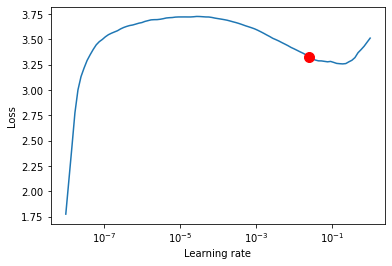

In [68]:
# Define sdl; only for finding optimal lr
sdl = DCCA_SDL(Models.latent_dims,optimizer='sgd',
                N=Models.N, encoders=[Models.encoder_1,Models.encoder_2],
                lam=0.0001, 
                objective=objectives.CCA) # train size

#define sdl trainer only for finding opt lr
trainer_sdl = pl.Trainer(
        max_epochs=Models.epochs, log_every_n_steps=1)

print('\n','-'*20,'\n Finding opt SDL lr \n','-'*20)

# run lr finder
lr_finder = trainer_sdl.tuner.lr_find(sdl,Models.train_loader,
                                      Models.val_loader,
                                      early_stop_threshold=None)
#update sdl lr
Models.sdl_lr = lr_finder.suggestion()
#plot lr suggestion
fig = lr_finder.plot(suggest=True)


In [69]:
Models.sdl_lr


0.025118864315095822

#### Find Optimal Learning rate for DCCA model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



 -------------------- 
 Finding opt DCCA lr 
 --------------------


Finding best initial lr:   0%|          | 0/128 [00:00<?, ?it/s]

Restoring states from the checkpoint path at C:\Users\lmeli\Desktop\Thesis\raw_data\.lr_find_a431448d-58be-4589-beeb-86416c70c7c8.ckpt


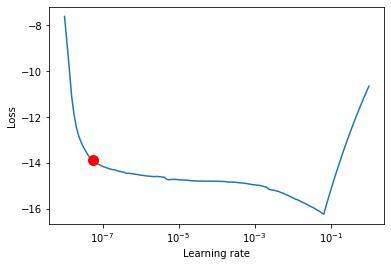

In [50]:
# Define dcca; only for finding optimal lr
dcca = DCCA(
        latent_dims=Models.latent_dims,
        encoders=[Models.encoder_1, Models.encoder_2],
        objective=objectives.CCA,
        optimizer='sgd',
        lr=Models.dcca_lr)

#define dcca trainer only for finding opt lr
trainer_dcca = pl.Trainer(
        max_epochs=Models.epochs, log_every_n_steps=1)

print('\n','-'*20,'\n Finding opt DCCA lr \n','-'*20)

# run lr finder
lr_finder = trainer_dcca.tuner.lr_find(dcca,Models.train_loader,Models.val_loader,early_stop_threshold=None,num_training=128)
#update dcca lr
Models.dcca_lr = lr_finder.suggestion()
#plot lr suggestion
fig = lr_finder.plot(suggest=True)


In [51]:
Models.dcca_lr

5.623413251903491e-08

### GIVE Details on tensorboard and checkpoints !!!!

In [54]:

%load_ext tensorboard
%tensorboard --logdir=./sdl_logs/sdl_optimal_batch_size --host localhost --port 8082
   

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Find optimal batch_size for SDL

In [1]:
%%time
for i in range(6):
    Models.batch_size = 128 * (i+1) 
    
    version =  f'sdl_batch_size_{128*(i+1)}'
   
    experiment_dir = './sdl_logs'
    model_checkpoint = ModelCheckpoint(save_top_k = 1,
                                       monitor="val/l2",
                                       mode = 'min')

    logger = TensorBoardLogger(save_dir=experiment_dir, 
                                   name='sdl_optimal_batch_size',
                                   version = version)
    # train sdl
    Models.train_sdl(model_checkpoint, logger) 

  

### Load the trained model from checkpoint

Documentation on loading pytorch lightning model from a checkpoint can be found [here](https://pytorch-lightning.readthedocs.io/en/stable/common/checkpointing_basic.html)


From the tensorboard we observe that the batch size of 128 shows signs of 'learning' (metrics improve along training) while the larger batch_sizes do not show improvements along training.

Here I load the two models, sdl_batch_size_128 (sdl_128) and sdl_batch_size_768 (sdl_768) and see how there transformations compare

In [106]:

sdl = DCCA_SDL(latent_dims = 25,N=29841) # set up the model base

#load pretrained sdl_batch_size_128 (sdl_128)
sdl_128 = sdl.load_from_checkpoint('./sdl_logs/sdl_optimal_batch_size/sdl_batch_size_128/checkpoints/epoch=280-step=12083.ckpt',
                                 
                                 latent_dims = 25, N=29841, 
                                 optimizer=Models.optim,
                                 encoders = [Models.encoder_1,Models.encoder_2],
                                 lam=0.0001, 
                                 dropout=0.05,
                                 objective=Models.objective
                                 )
sdl_128.eval() # to drop randomness as mentioned in documentation



#load pretrained sdl_batch_size_256 (sdl_256)
sdl_256 = sdl.load_from_checkpoint('./sdl_logs/sdl_optimal_batch_size/sdl_batch_size_256/checkpoints/epoch=0-step=43.ckpt',
                                 
                                 latent_dims = 25, N=29841, 
                                 optimizer=Models.optim,
                                 encoders = [Models.encoder_1,Models.encoder_2],
                                 lam=0.0001, 
                                 dropout=0.05,
                                 objective=Models.objective
                                 )
sdl_256.eval() # to drop randomness as mentioned in documentation
    

    

#load pretrained sdl_batch_size_384 (sdl_384)
sdl_384 = sdl.load_from_checkpoint('./sdl_logs/sdl_optimal_batch_size/sdl_batch_size_384/checkpoints/epoch=0-step=43.ckpt',
                                 
                                 latent_dims = 25, N=29841, 
                                 optimizer=Models.optim,
                                 encoders = [Models.encoder_1,Models.encoder_2],
                                 lam=0.0001, 
                                 dropout=0.05,
                                 objective=Models.objective
                                 )
sdl_384.eval() # to drop randomness as mentioned in documentation

#load pretrained sdl_batch_size_512 (sdl_512)
sdl_512 = sdl.load_from_checkpoint('./sdl_logs/sdl_optimal_batch_size/sdl_batch_size_512/checkpoints/epoch=0-step=43.ckpt',
                                 
                                 latent_dims = 25, N=29841, 
                                 optimizer=Models.optim,
                                 encoders = [Models.encoder_1,Models.encoder_2],
                                 lam=0.0001, 
                                 dropout=0.05,
                                 objective=Models.objective
                                 )
sdl_512.eval() # to drop randomness as mentioned in documentation


#load pretrained sdl_batch_size_640 (sdl_640)
sdl_640 = sdl.load_from_checkpoint('./sdl_logs/sdl_optimal_batch_size/sdl_batch_size_640/checkpoints/epoch=0-step=43.ckpt',
                                 
                                 latent_dims = 25, N=29841, 
                                 optimizer=Models.optim,
                                 encoders = [Models.encoder_1,Models.encoder_2],
                                 lam=0.0001, 
                                 dropout=0.05,
                                 objective=Models.objective
                                 )
sdl_640.eval() # to drop randomness as mentioned in documentation
    
#load pretrained sdl_batch_size_768 (sdl_768)
sdl_768 = sdl.load_from_checkpoint('./sdl_logs/sdl_optimal_batch_size/sdl_batch_size_768/checkpoints/epoch=0-step=43.ckpt',
                                 
                                 latent_dims = 25, N=29841, 
                                 optimizer=Models.optim,
                                 encoders = [Models.encoder_1,Models.encoder_2],
                                 lam=0.0001, 
                                 dropout=0.05,
                                 objective=Models.objective
                                 )
sdl_768.eval()

DCCA_SDL(
  (encoders): ModuleList(
    (0): Encoder(
      (layers): Sequential(
        (0): Sequential(
          (0): Dropout(p=0, inplace=False)
          (1): Linear(in_features=200, out_features=500, bias=True)
          (2): LeakyReLU(negative_slope=0.01)
        )
        (1): Sequential(
          (0): Dropout(p=0, inplace=False)
          (1): Linear(in_features=500, out_features=300, bias=True)
          (2): LeakyReLU(negative_slope=0.01)
        )
        (2): Sequential(
          (0): Dropout(p=0, inplace=False)
          (1): Linear(in_features=300, out_features=300, bias=True)
          (2): LeakyReLU(negative_slope=0.01)
        )
      )
      (fc): Sequential(
        (0): Dropout(p=0, inplace=False)
        (1): Linear(in_features=300, out_features=25, bias=True)
      )
    )
    (1): Encoder(
      (layers): Sequential(
        (0): Sequential(
          (0): Dropout(p=0, inplace=False)
          (1): Linear(in_features=300, out_features=500, bias=True)
        

### Transform dataset using the loaded models

In [112]:
# sdl_128
models = [sdl_128,sdl_256,sdl_384,sdl_512,sdl_640,sdl_768]

for i, model in enumerate(models):
    z1_test, z2_test = model.transform(loader=Models.test_loader) # get test z transformations
    z1_train, z2_train = model.transform(loader=Models.train_loader) # get train z transformations


    #update the df with z score from the sdl_128
    # 1. update test_df
    Models.update_z_scores(dataset='test',z1=z1_test,
                       z2=z2_test, 
                       cols=[f'sdl_{128*(i+1)}_z1',f'sdl_{128*(i+1)}_z2'])
    # 2. update train_df
    Models.update_z_scores(dataset='train',z1=z1_train,
                       z2=z2_train, 
                       cols=[f'sdl_{128*(i+1)}_z1',f'sdl_{128*(i+1)}_z2'])




In [113]:
Models.train_df.head(3) #check that updates are okay

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,sdl_128_z1,sdl_128_z2,sdl_768_z1,sdl_768_z2,sdl_256_z1,sdl_256_z2,sdl_384_z1,sdl_384_z2,sdl_512_z1,sdl_512_z2,sdl_640_z1,sdl_640_z2
31078,NC1=NC(O)=NC(O)=N1,YSKUZVBSHIWEFK-UHFFFAOYSA-N,YSKUZVBSHIWEFK,spec_id29646,"[0.39132802078430906, 8.898871522206163, -5.26...","[0.0, 3.822970151901245, 0.6844741106033325, 3...","[2.82266, -0.6370032, -2.0535321, 4.1250057, 0...",Triazines,"[0.111999825, -0.307954, -0.11916247, 0.071486...","[0.09219781, -0.31669635, -0.14787935, 0.07566...","[0.086307526, -0.15682718, -0.11104174, 0.0738...","[0.08580619, -0.16565931, -0.11387258, 0.07148...","[0.102911204, -0.23754372, -0.11142577, 0.0643...","[0.09042359, -0.31664407, -0.13779372, 0.07239...","[0.087395445, -0.1793378, -0.10652813, 0.06870...","[0.08246046, -0.22075628, -0.12037399, 0.06823...","[0.08544527, -0.1683225, -0.11146736, 0.070824...","[0.084217906, -0.18833497, -0.117551535, 0.070...","[0.08820349, -0.16098976, -0.113391936, 0.0723...","[0.08311117, -0.17364407, -0.11539122, 0.07035..."
5017,C(CCN1CCC(CC1)N2C3=C(NC2=O)C=C(C=C3)Cl)N4C(NC5...,FGXWKSZFVQUSTL-UHFFFAOYSA-N,FGXWKSZFVQUSTL,spec_id4540,"[-2.109642793503982, 9.172110314461383, -3.761...","[0.0, 0.0, 3.919229745864868, 0.0, 0.0, 0.0, 0...","[2.0561442, -7.7538767, -3.2893913, 10.2877445...",Benzimidazoles,"[0.11103523, -0.3006176, -0.109297514, 0.07529...","[0.106414944, -0.33946016, -0.16211131, 0.0796...","[0.08539021, -0.1525535, -0.10264863, 0.077616...","[0.09828202, -0.18139887, -0.12661342, 0.07547...","[0.1019903, -0.23144767, -0.10215649, 0.068119...","[0.10413397, -0.33870497, -0.15168804, 0.07636...","[0.08640413, -0.17353413, -0.09689313, 0.07278...","[0.09624894, -0.24036595, -0.13454887, 0.07247...","[0.0844921, -0.16326891, -0.10253899, 0.074738...","[0.09737998, -0.2059673, -0.13137479, 0.075152...","[0.08727367, -0.15641254, -0.104751155, 0.0761...","[0.09609141, -0.19020225, -0.12858608, 0.07442..."
25692,O=C1C2(CN3CC1(CN(C2)C3C=4C=5C=CC=CC5N(C4C)CC)C...,KRYFHYSXWHRZKT-UHFFFAOYSA-N,KRYFHYSXWHRZKT,spec_id25573,"[-7.813952363837433, 21.489215424348487, 0.139...","[0.0, 0.0, 2.080496311187744, 33.9843330383300...","[-0.29133967, -1.4593705, -1.5894933, 5.066439...",Indoles and derivatives,"[0.11348097, -0.2612695, -0.12864304, 0.070392...","[0.09717206, -0.3449157, -0.1545397, 0.0713648...","[0.08771607, -0.12963212, -0.11910783, 0.07282...","[0.09017119, -0.18517098, -0.119835116, 0.0672...","[0.10432525, -0.1987521, -0.120333865, 0.06329...","[0.09522053, -0.34399205, -0.14429606, 0.06813...","[0.08891763, -0.14240666, -0.115787715, 0.0675...","[0.08728473, -0.24506555, -0.12700763, 0.06368...","[0.08690886, -0.13616446, -0.12004785, 0.06969...","[0.088823006, -0.21019304, -0.12402062, 0.0664...","[0.08963123, -0.13186303, -0.121696025, 0.0712...","[0.08765265, -0.19417056, -0.12156623, 0.06599..."


### Find better number of latent dimension to train deep models

In [4]:
%%time
corr = []

dims = [10, 20, 30, 40, 50] # we already found that more than 50 is not good choice

for dim in dims:
    
    # latent_dimste deepcca objec
    Models = DeepCCA(df_all)
    
    #set the latent dimentions to dim
    Models.latent_dims = dim
    
    # generate data loaders and cca v1,v2
    Models.deepcca_dataloaders()

    # set up the encoders
    Models.deepcca_encoders()
    
    # train cca
    Models.train_cca() # will look at this for opti

    # score the models: it runs cca.score

    cca_train_corr = Models.score(model='cca', dataset='train')
    cca_test_corr = Models.score(model='cca', dataset='test')

    corr.append([f'cca_dims_{dim}',cca_train_corr, cca_test_corr])
    
    
    # train sdl
    Models.train_sdl() # will look at this for opti

    # score the models: it runs sdl.score()

    sdl_train_corr =Models.score(model='sdl', dataset='train')
    sdl_test_corr = Models.score(model='sdl', dataset='test')

    corr.append([f'sdl_dims_{dim}',sdl_train_corr, sdl_test_corr])

    
    # train dcca
    Models.train_dcca() # will look at this for opti

    # score the models: it runs dcca.score()

    dcca_train_corr =Models.score(model='dcca', dataset='train')
    dcca_test_corr = Models.score(model='dcca', dataset='test')

   
    corr.append([f'dcca_dims_{dim}',dcca_train_corr, dcca_test_corr])
    

#### Plot the test correlation from the tried dims

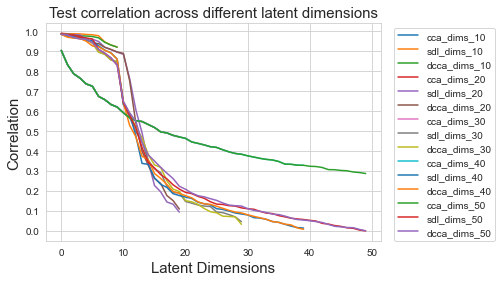

In [32]:
legend = [x[0] for x in corr]
fig, ax = plt.subplots()
sns.set_style('whitegrid')
for cor in corr:
    sns.lineplot(x=[x for x in range(len(cor[1]))],
                                     y=cor[1],\
                 #color = palette[i],
                 #linestyle=line[1], 
                                     ax=ax)
    plt.legend(labels=legend,loc=(1.04, 0.0),title='Model')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xlabel('Latent Dimensions', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Test correlation across different latent dimensions', fontsize=15)
plt.show()

#### Seems dims of 10 are better train with 10 dims and see tanis

In [16]:

# latent_dims te deepcca objec
Models = DeepCCA(df_all)
    
    #set the latent dimentions to dim
Models.latent_dims = 10
    
    # generate data loaders and cca v1,v2
Models.deepcca_dataloaders()

    # set up the encoders
Models.deepcca_encoders()
    
    # train cca
Models.train_cca() # will look at this for opti

    # score the models: it runs cca.score

cca_train_corr = Models.score(model='cca', dataset='train')
cca_test_corr = Models.score(model='cca', dataset='test')
    #cca transform: runs cca.transform and update the df with z scores
# Models.transform(model='cca', dataset='train')
# Models.transform(model='cca', dataset='test')

    #corr.append([f'cca_dims_{dim}',cca_train_corr, cca_test_corr])
    
  


 -------------------- 
 Training CCA
 --------------------


In [5]:
%reload_ext tensorboard
%tensorboard --logdir= './sdl/lightning_logs' --host localhost --port 8088
    # train sdl
Models.train_sdl() # will look at this for opti

    # score the models: it runs sdl.score()

sdl_train_corr =Models.score(model='sdl', dataset='train')
sdl_test_corr = Models.score(model='sdl', dataset='test')
    
    #sdl transform: runs sdl.transform and update the df with z scores
# Models.transform(model='sdl', dataset='train')
# Models.transform(model='sdl', dataset='test')

    #corr.append([f'sdl_dims_{dim}',sdl_train_corr, sdl_test_corr])

    


In [6]:
# train dcca
Models.train_dcca() # will look at this for opti

# score the models: it runs dcca.score()

dcca_train_corr =Models.score(model='dcca', dataset='train')
dcca_test_corr = Models.score(model='dcca', dataset='test')
    
#dcca transform: runs dcca.transform and update the df with z scores
Models.transform(model='dcca', dataset='train')
Models.transform(model='dcca', dataset='test')
   
    #corr.append([f'dcca_dims_{dim}',dcca_train_corr, dcca_test_corr])

In [42]:
#write corr to file
path = './testing_dims_corr_only_test_corr.pickle'
Files(path).write_to_file(corr)

In [44]:
# To construct image name
embedding = 'MS2DeepScore'
method = 'ALL_3_hidden_opt_lr_dim_10'
data = 'max3'
dims = 10 #latent_dims

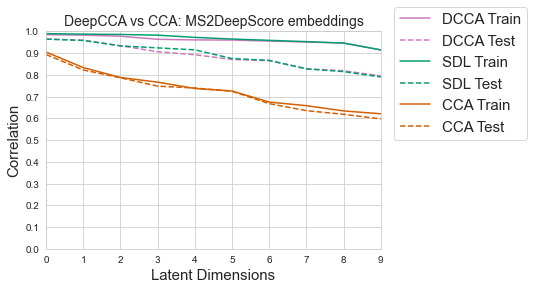

In [184]:
# plot train correlation vs test correlation
x=[x for x in range(dims)]
fig, ax = plt.subplots()

sns.set_style('whitegrid')

line = ['solid', 'dashed']

#justice for the color blind :)
palette = [sns.color_palette("colorblind")[4],\
           sns.color_palette("colorblind")[2],\
           sns.color_palette("colorblind")[3]]

dfs = [[dcca_train_corr, dcca_test_corr],\
       [sdl_train_corr, sdl_test_corr],\
       [cca_train_corr,cca_test_corr]]

for i, df in enumerate(dfs):
    #train
    sns.lineplot(x=[x for x in range(10)],y=df[0], \
                 color = palette[i],
                 linestyle=line[0],ax=ax)
    #test
    sns.lineplot(x=x,y=df[1],\
                 color = palette[i],
                 linestyle=line[1], ax=ax)

    plt.legend(labels=['DCCA Train', 'DCCA Test',\
                      'SDL Train', 'SDL Test',\
                      'CCA Train', 'CCA Test'], \
                       loc=(1.04, 0.5),\
                    fontsize=15)#title='Algorithm', 
plt.xlabel('Latent Dimensions', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.ylim(0, 1.0)
plt.title(label=f'DeepCCA vs CCA: {embedding} embeddings',\
          fontsize=14,loc='center')
plt.xlim(0, 9)
plt.xticks(np.arange(0, 9.01, step=1))
plt.yticks(np.arange(0, 1.01, step=0.1))
plt.savefig(f'../plots/{method}_{data}_{dims}_vs_cca_{embedding}.png',\
           transparent=False,bbox_inches = 'tight')
plt.show()

#what is the probability that dcca and sdl are ~ the same; something wrong?


In [164]:
len(dcca_train_corr)

10

In [6]:
#write dfs (with the z score from dcca,cca and sdl) to file

dfs = [Models.train_df,Models.test_df,Models.val_df]

paths = ['./max3_sdl_dims_10_best_train_df_with_z.pickle',
        './max3_sdl_dims_10_test_df_with_z.pickle',
        './max3_sdl_dims_10_val_df_with_z.pickle']

for df, path in zip(dfs,paths):
    Files(path).write_to_file(df)
    

In [7]:
paths = ['./max3_sdl_dims_10_best_train_df_with_z.pickle',
        './max3_sdl_dims_10_test_df_with_z.pickle',
        './max3_sdl_dims_10_val_df_with_z.pickle']

train_df = Files(paths[0]).load_pickle()
test_df = Files(paths[1]).load_pickle()

### Assess Prediction Performance: DCCA

##### Predict Structure from spectra Embeddings

1. Calculate:(using euc only for now since its faster)

    1. Euclidean Distance
    2. Cosine Distance
    3. Correlation

2. Calculate Tanimoto score of top scoring hits based on the above metric

3. Sample a few structures to draw

In [11]:
def predict(subject_df,query_df,\
            method,dims,metric='euc'): #both dfs should have z1 and z2 coloumns

    preds = {}
    
    for query_index, query in enumerate(query_df[f'{method}_z1']): #(query z1)
        
        #calculate tanimotos if it does not meet threshold;pass
        
        #query = query_df.loc[query_index,'z1']
        preds[query_index] = []
        for subject in subject_df[f'{method}_z2']:#(subject z2)
        
            #subject = subject_df.loc[subject_index,'z2']
            if metric == 'corr':
                corr = pearsonr(query[:dims], subject[:dims])[0]
                preds[query_index].append(corr)
        
            if metric== 'euc':
                euc = distance.euclidean(query[:dims], subject[:dims])
                preds[query_index].append(euc)
        
            if metric == 'cos':
                cos = distance.cosine(query[:dims], subject[:dims])
                preds[query_index].append(cos)
    
    return preds
    

In [12]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from tqdm import tqdm

In [13]:
# function to calculate pairwise tanimoto scores
def tanimoto(smi1, smi2):
    #molecule
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    #fingerprint
    fp1 = Chem.RDKFingerprint(mol1)
    fp2 = Chem.RDKFingerprint(mol2)
    
    #similarity
    score = round(DataStructs.FingerprintSimilarity(fp1,fp2),4)
    return score

In [14]:
# function to calculate tanimoto scores for n hits returns a max tanimotos and {query:top_hit}
def get_tanimotos(preditions_dict,\
                  subject_df,query_df, metric,nn=20):
    tanimotos = []
    pred = {} #key is the query index, value is the top hit index
    
    for query_index, values in preditions_dict.items(): # values == score(corr, euc or cosine)
        pred[query_index] = []
        
        #select top n hits for each query based on correlation
        if metric == 'corr':
            top_hits = np.sort(values)[::-1][:nn] # higher corr the better
            
            #calculate tanimoto scores for each of the top 5 hits
            top_hits_scores = []
            subject_hit_indices = []
            for hit in top_hits:
                
                subject_index = values.index(hit)
                subject_hit_indices.append(subject_index) #to trace the index of the hits
                    
                smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
                smile2= query_df['smiles'].iloc[query_index]#extract the query smile 
                top_hits_scores.append(tanimoto(smile1,smile2))
                #select the max tanimoto score 
            tanimotos.append(max(top_hits_scores))
            
            pred[query_index].append([subject_hit_indices[np.argmax(top_hits_scores)],max(top_hits_scores)]) #appends the index of the hit with highest tanimoto
            
        #select closest n hits for each query based on cosine/euclidian distance
        else: #may be elif metric != 'corr'
            top_hits = np.sort(values)[:nn] #if its euc or cos; the lower the better
    
            #calculate tanimoto scores for each of the top 5 hits
            top_hits_scores = []
            subject_hit_indices = []
            for hit in top_hits:
                
                
                
                subject_index = values.index(hit)
                subject_hit_indices.append(subject_index) #to trace the index of the hits
                    
                smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
                smile2= query_df['smiles'].iloc[query_index]#extract the query smile 
                top_hits_scores.append(tanimoto(smile1,smile2))
            #select the max tanimoto score 
            tanimotos.append(max(top_hits_scores))
            pred[query_index].append([subject_hit_indices[np.argmax(top_hits_scores)],max(top_hits_scores)])#appends the index of the hit with highest tanimoto
    return tanimotos, pred
    

In [15]:
def random_tanimoto(preditions_dict,
                subject_df,query_df):
    tanimotos = []
    
    for query_index, values in preditions_dict.items():
        subject_index = random.randint(0,len(values)) #randomly pick subject index as hits
        
        smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
        smile2 = query_df['smiles'].iloc[query_index]#extract the query smile 
        
        tanimotos.append(tanimoto(smile1,smile2))
    return tanimotos
        
        

#### Calculate the predictions from each of the loaded models (different batch sizes)

In [148]:
%%time

dims = 25
size = 1000
metric = 'euc' 

euc_all = []
hits = []
tanis = []
methods = ['sdl_128','sdl_256','sdl_384','sdl_512','sdl_640', 'sdl_768'] #models

for method in methods:
    dist = predict(subject_df=Models.train_df,\
                        query_df=Models.test_df.head(size),dims=dims,\
                        method=method, metric='euc')
    
    tan, hit = get_tanimotos(dist,subject_df=Models.train_df,\
                                query_df=Models.test_df.head(size),\
                                    metric='euc')
    euc_all.append(dist)
    hits.append(hit)
    tanis.append(tan)




[16:38:19] WARNING: not removing hydrogen atom without neighbors


Wall time: 26min 36s


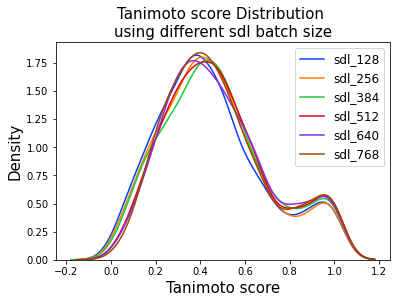

In [149]:
#plot the distribution of the three top tanimotos from the three metrics

palette = sns.color_palette("bright") 
           
for i, tan in enumerate(tanis):
    ax=sns.kdeplot(x=tan,color = palette[i],shade=False)
plt.legend(labels=methods, loc='upper right', fontsize=12)
plt.xlabel('Tanimoto score', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title(label='Tanimoto score Distribution \nusing different sdl batch size', fontsize=15)
# plt.savefig(f'../plots/max3_tanimoto_euc_distribution.png',\
#            transparent=False,bbox_inches = 'tight')
plt.show()

In [33]:
 %%time
test_sdl_corr_dim_10 = predict(subject_df=train_df,\
                        query_df=test_df,dims=dims,\
                        method='sdl', metric='corr')

#tanimotos, and the top hit  using corr  
test_sdl_corr_dim_10_tanimotos, hits_sdl_corr_dim_10 = get_tanimotos(test_sdl_corr_dim_10, \
                                       subject_df=train_df,\
                                        query_df=test_df,\
                                        metric='corr')


[02:43:24] WARNING: not removing hydrogen atom without neighbors
[02:44:16] WARNING: not removing hydrogen atom without neighbors
[02:44:22] WARNING: not removing hydrogen atom without neighbors
[02:45:43] WARNING: not removing hydrogen atom without neighbors
[02:45:52] WARNING: not removing hydrogen atom without neighbors
[02:46:33] WARNING: not removing hydrogen atom without neighbors
[02:46:39] WARNING: not removing hydrogen atom without neighbors
[02:46:41] WARNING: not removing hydrogen atom without neighbors
[02:47:13] WARNING: not removing hydrogen atom without neighbors
[02:47:36] WARNING: not removing hydrogen atom without neighbors
[02:47:49] WARNING: not removing hydrogen atom without neighbors
[02:48:28] WARNING: not removing hydrogen atom without neighbors
[02:48:32] WARNING: not removing hydrogen atom without neighbors
[02:49:04] WARNING: not removing hydrogen atom without neighbors
[02:49:59] WARNING: not removing hydrogen atom without neighbors
[02:50:36] WARNING: not r

Wall time: 2h 51min 20s


In [ ]:

%%time
test_sdl_cos_dim_10 = predict(subject_df=train_df,\
                        query_df=test_df,dims=dims,\
                        method='sdl', metric='cos')
#tanimotos, and the top hit  using cos  
test_sdl_cos_dim_10_tanimotos, hits_sdl_cos_dim_10 = get_tanimotos(test_sdl_cos_dim_10, \
                                       subject_df=train_df,\
                                        query_df=test_df,\
                                        metric='cos')


In [35]:
#random tanimotos
random_tanimotos = random_tanimoto(test_sdl_cos_dim_10, \
                                       subject_df=train_df,\
                                       query_df=test_df)


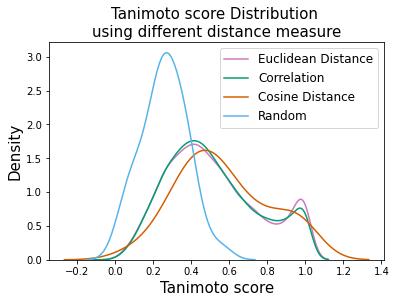

In [44]:
#plot the distribution of the three top tanimotos from the three metrics

palette = [sns.color_palette("colorblind")[4], #euc
           sns.color_palette("colorblind")[2], #corr
           sns.color_palette("colorblind")[3], #cos
          sns.color_palette("colorblind")[9]] #random
dist_list = [test_sdl_euc_dim_10_tanimotos,
             test_sdl_corr_dim_10_tanimotos,
             test_sdl_cos_dim_10_tanimotos,
            random_tanimotos]
for i, dist in enumerate(dist_list):
    ax=sns.kdeplot(x=dist,color = palette[i],shade=False)
plt.legend(labels=['Euclidean Distance',
                   'Correlation',
                   'Cosine Distance',
                   'Random'
                  ], loc='upper right', fontsize=12)
plt.xlabel('Tanimoto score', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title(label='Tanimoto score Distribution \nusing different distance measure', fontsize=15)
# plt.savefig(f'../plots/max3_tanimoto_euc_distribution.png',\
#            transparent=False,bbox_inches = 'tight')
plt.show()

In [37]:
dists= [test_sdl_euc_dim_10,test_sdl_corr_dim_10,test_sdl_cos_dim_10]
hits = [hits_sdl_euc_dim_10,hits_sdl_corr_dim_10,hits_sdl_cos_dim_10]
tanis = [test_sdl_euc_dim_10_tanimotos,test_sdl_corr_dim_10_tanimotos,test_sdl_cos_dim_10_tanimotos]




In [43]:
len(dists[0])

8290

In [105]:
# paths = ['./max3_sdl_euc_dims_10.pickle', './max3_sdl_corr_dims_10.pickle','./max3_sdl_cos_dims_10.pickle']

# for euc, path in zip(dists,paths):
#     Files(path).write_to_file(euc)

In [ ]:
paths = ['./max3_sdl_euc_hits_dims_10_20_nn.pickle', './max3_sdl_hits_corr_dims_10_20_nn.pickle','./max3_sdl_hits_cos_dims_10_20_nn.pickle']

for hit, path in zip(hits,paths):
    Files(path).write_to_file(hit)

In [40]:
paths = ['./max3_sdl_euc_tanimoto_dims_10_20_nn.pickle', './max3_sdl_corr_tanimoto_dims_10_20_nn.pickle','./max3_sdl_cos_tanimoto_dims_10_20_nn.pickle']

for tan, path in zip(tanis,paths):
    Files(path).write_to_file(tan)

In [67]:
%%time

dims = 10
#n=50
nn=10
metric = 'euc'
#predict sdl euc
test_sdl_euc = predict(subject_df=Models.train_df,\
                        query_df=Models.test_df,dims=dims,\
                        method='sdl', metric=metric)
#tanimotos, and the top hit    
test_sdl_euc_tanimotos, hits_sdl = get_tanimotos(test_sdl_euc, \
                                       subject_df=Models.train_df,\
                                        query_df=Models.test_df,\
                                        metric=metric)
# dcca
test_dcca_euc = predict(subject_df=Models.train_df,\
                        query_df=Models.test_df,dims=dims,\
                        method='dcca', metric=metric)
#tanimotos, and the top hit    
test_dcca_euc_tanimotos, hits_dcca = get_tanimotos(test_dcca_euc, \
                                       subject_df=Models.train_df,\
                                        query_df=Models.test_df,\
                                        metric=metric)

#cca
test_cca_euc = predict(subject_df=Models.train_df,\
                       query_df=Models.test_df,dims=dims,\
                       method='cca',metric=metric)
#tanimotos, and the top hit 
test_cca_euc_tanimotos,hits_cca = get_tanimotos(test_cca_euc, \
                       subject_df=Models.train_df,\
                       query_df=Models.test_df, \
                                       metric=metric)

#random tanimotos
random_tanimotos = random_tanimoto(test_cca_euc, \
                                       subject_df=Models.train_df,\
                                       query_df=Models.test_df)



[00:14:20] WARNING: not removing hydrogen atom without neighbors
[00:14:21] WARNING: not removing hydrogen atom without neighbors
[00:15:00] WARNING: not removing hydrogen atom without neighbors
[00:15:22] WARNING: not removing hydrogen atom without neighbors
[00:15:25] WARNING: not removing hydrogen atom without neighbors
[00:16:36] WARNING: not removing hydrogen atom without neighbors
[00:17:02] WARNING: not removing hydrogen atom without neighbors
[00:17:58] WARNING: not removing hydrogen atom without neighbors
[00:43:48] WARNING: not removing hydrogen atom without neighbors


Wall time: 1h 29min 22s


In [150]:
%%time
#tanimotos, and the top hit    
test_sdl_euc_tanimotos, hits_sdl_20_nn = get_tanimotos(test_sdl_euc, \
                                       subject_df=Models.train_df,\
                                        query_df=Models.test_df,\
                                        metric=metric,nn=20)

[11:05:08] WARNING: not removing hydrogen atom without neighbors
[11:05:17] WARNING: not removing hydrogen atom without neighbors
[11:07:04] WARNING: not removing hydrogen atom without neighbors
[11:08:00] WARNING: not removing hydrogen atom without neighbors
[11:08:02] WARNING: not removing hydrogen atom without neighbors
[11:08:42] WARNING: not removing hydrogen atom without neighbors
[11:09:28] WARNING: not removing hydrogen atom without neighbors
[11:10:16] WARNING: not removing hydrogen atom without neighbors
[11:10:22] WARNING: not removing hydrogen atom without neighbors
[11:12:56] WARNING: not removing hydrogen atom without neighbors
[11:13:52] WARNING: not removing hydrogen atom without neighbors
[11:15:57] WARNING: not removing hydrogen atom without neighbors
[11:18:35] WARNING: not removing hydrogen atom without neighbors


Wall time: 14min 30s


In [154]:
%%time
#tanimotos, and the top hit 
test_cca_euc_tanimotos,hits_cca_20_nn = get_tanimotos(test_cca_euc, \
                       subject_df=Models.train_df,\
                       query_df=Models.test_df, \
                                       metric=metric, nn=20)

Wall time: 12min 51s


In [156]:
%%time
#tanimotos, and the top hit    
test_dcca_euc_tanimotos, hits_dcca_20_nn = get_tanimotos(test_dcca_euc, \
                                       subject_df=Models.train_df,\
                                        query_df=Models.test_df,\
                                        metric=metric,nn=20)

[11:58:57] WARNING: not removing hydrogen atom without neighbors


Wall time: 12min 56s


In [ ]:
eucs = [test_sdl_euc,test_dcca_euc,test_cca_euc]
hits = [hits_sdl_20_nn,hits_dcca_20_nn,hits_cca_20_nn]
tanis = [test_sdl_euc_tanimotos,test_dcca_euc_tanimotos,test_cca_euc_tanimotos]




In [69]:
paths = ['./max3_sdl_euc_dims_10.pickle', './max3_dcca_euc_dims_10.pickle','./max3_cca_euc_dims_10.pickle']

for euc, path in zip(eucs,paths):
    Files(path).write_to_file(euc)

In [ ]:
paths = ['./max3_sdl_hits_dims_10_20_nn.pickle', './max3_dcca_hits_dims_10_20_nn.pickle','./max3_cca_hits_dims_10_20_nn.pickle']

for hit, path in zip(hits,paths):
    Files(path).write_to_file(hit)

In [ ]:
paths = ['./max3_sdl_tanimoto_dims_10_20_nn.pickle', './max3_dcca_tanimoto_dims_10_20_nn.pickle','./max3_cca_tanimoto_dims_10_20_nn.pickle']

for tan, path in zip(tanis,paths):
    Files(path).write_to_file(tan)

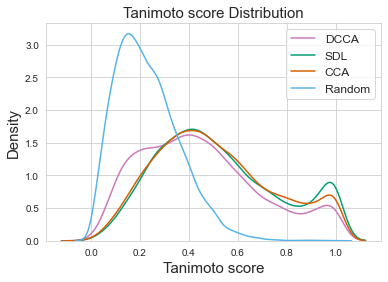

In [157]:
#plot the distribution of the three top tanimotos from the three metrics

palette = [sns.color_palette("colorblind")[4], #DCCA
           sns.color_palette("colorblind")[2], #SDL
           sns.color_palette("colorblind")[3], #CCA
          sns.color_palette("colorblind")[9]] #random
dist_list = [test_dcca_euc_tanimotos,
             test_sdl_euc_tanimotos,
             test_cca_euc_tanimotos,
            random_tanimotos]
for i, dist in enumerate(dist_list):
    ax=sns.kdeplot(x=dist,color = palette[i],shade=False)
plt.legend(labels=['DCCA',
                   'SDL',
                   'CCA',
                   'Random'
                  ], loc='upper right', fontsize=12)
plt.xlabel('Tanimoto score', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title(label='Tanimoto score Distribution', fontsize=15)
# plt.savefig(f'../plots/max3_tanimoto_euc_distribution.png',\
#            transparent=False,bbox_inches = 'tight')
plt.show()

#### Draw Random predicted molecule

In [4]:
#os.listdir()

In [20]:
# load hits
paths = ['./max3_sdl_hits.pickle','./max3_dcca_hits.pickle','./max3_cca_hits.pickle']
hits_sdl = Files(paths[0]).load_pickle()
hits_dcca = Files(paths[1]).load_pickle()
hits_cca = Files(paths[2]).load_pickle()

In [22]:
#load dfs
paths = ['./max3_train_df_with_z.pickle',
        './max3_test_df_with_z.pickle',
        './max3_val_df_with_z.pickle']

train_df = Files(paths[0]).load_pickle()
test_df = Files(paths[1]).load_pickle()
val_df = Files(paths[2]).load_pickle()


In [23]:
from rdkit import Chem
from rdkit.Chem import Draw

In [25]:
# function to extract the query and subject molecule, its legend(class_tanimoto_with the hit), can also return tanis
def pick_hit_mols(hits_dict, 
              train_df,test_df,group=None,
              return_tanimoto=False,k=2,filterby='inchikey14'): #if group == [cf_class], set filterby to 'cf_class'
    mols = []
    tanimoto = []
    classes = []
    for query_index, subject_index in  hits_dict.items():
    
    
        query_smile = test_df['smiles'].iloc[query_index]
        query_class = test_df['cf_class'].iloc[query_index]
        query_inchi = test_df['inchikey14'].iloc[query_index]
        
        if group:
            
            if filterby == 'cf_class':
                if query_class not in group:
                    continue
            else:
                if query_inchi not in group:
                    continue
    
        if type(query_class) == float:
            query_class = 'NAN'
            #classes = [f'Query:\t{query_class}',]
    
        classes.append(f'Query_{query_index}: {query_class}')#else
    
        query = Chem.MolFromSmiles(query_smile)
    
        subject_smile = train_df['smiles'].iloc[subject_index[0][0]]
        subject = Chem.MolFromSmiles(subject_smile)
        cl = train_df['cf_class'].iloc[subject_index[0][0]]
        if type(cl) == float:
            cl = 'NAN'
        subject_class = f'\tHit_{query_index}: {cl}:\tTanimoto: {subject_index[0][1]}'
        #print(query_class,subject_class)
        classes.append(subject_class)
        mols.append(query)
        mols.append(subject) #to expand later to include top 5 hits
        tanimoto.append(subject_index[0][1])
    
    
    if return_tanimoto:
        return mols, classes, tanimoto
    else:
        return mols, classes

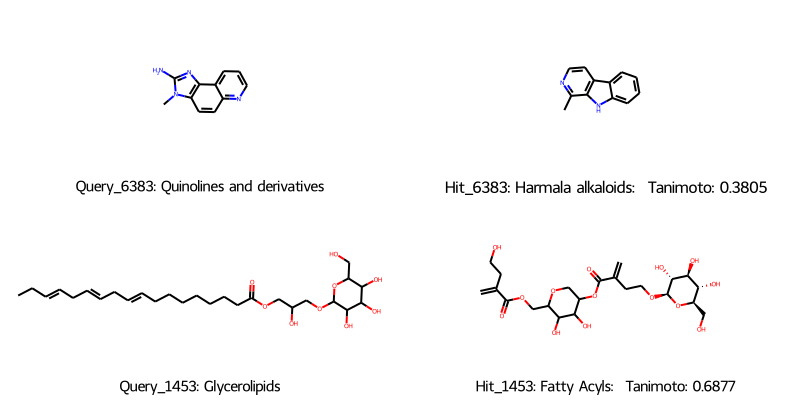

In [157]:
#randomly pick a query
keys = random.choices(list(hits_sdl.keys()),k=2)
subset_hits = {key: hits_sdl[key] for key in keys}

#draw the random queries plus their hits
sdl_random_mols, sdl_random_legends = pick_hit_mols(subset_hits,
                                                    train_df,test_df)
Draw.MolsToGridImage(sdl_random_mols,
                        molsPerRow=2, 
                        legends = sdl_random_legends,
                        subImgSize=(400,200),
                                returnPNG=True)


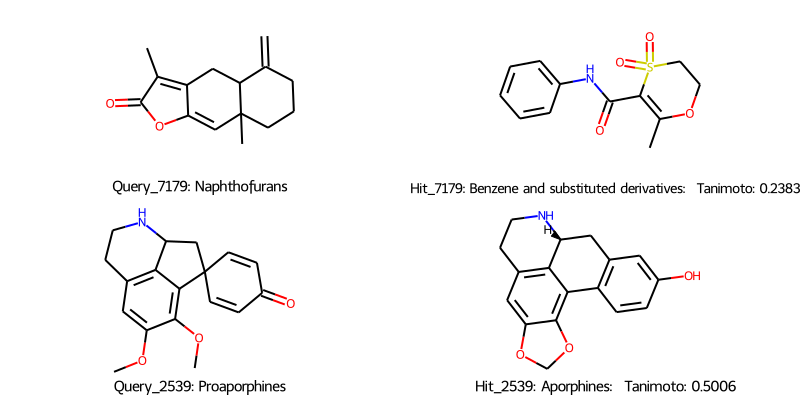

In [96]:

sdl_random_mols, sdl_random_legends = pick_hit_mols(subset_hits,
                                                    train_df,test_df)
Draw.MolsToGridImage(sdl_random_mols,
                        molsPerRow=2, 
                        legends = sdl_random_legends,
                        subImgSize=(400,200),
                                returnPNG=True)

### Test how the model performs with classes appearing less than 2 times

In [167]:
# select classes appearing < 2 times in the train dataset
train_rare_classes = train_df.groupby('cf_class').filter(lambda x : 2 >= len(x))
train_rare_classes.shape

(75, 14)

In [181]:
# select classes appearing < 2 times in the test dataset
test_rare_classes = test_df.\
loc[test_df['cf_class'].isin([x for x in \
                                         train_rare_classes['cf_class']])]

test_rare_classes.shape

(30, 14)

In [182]:
test_rare_classes = random.choices([x for x in test_rare_classes['cf_class']],k=10)

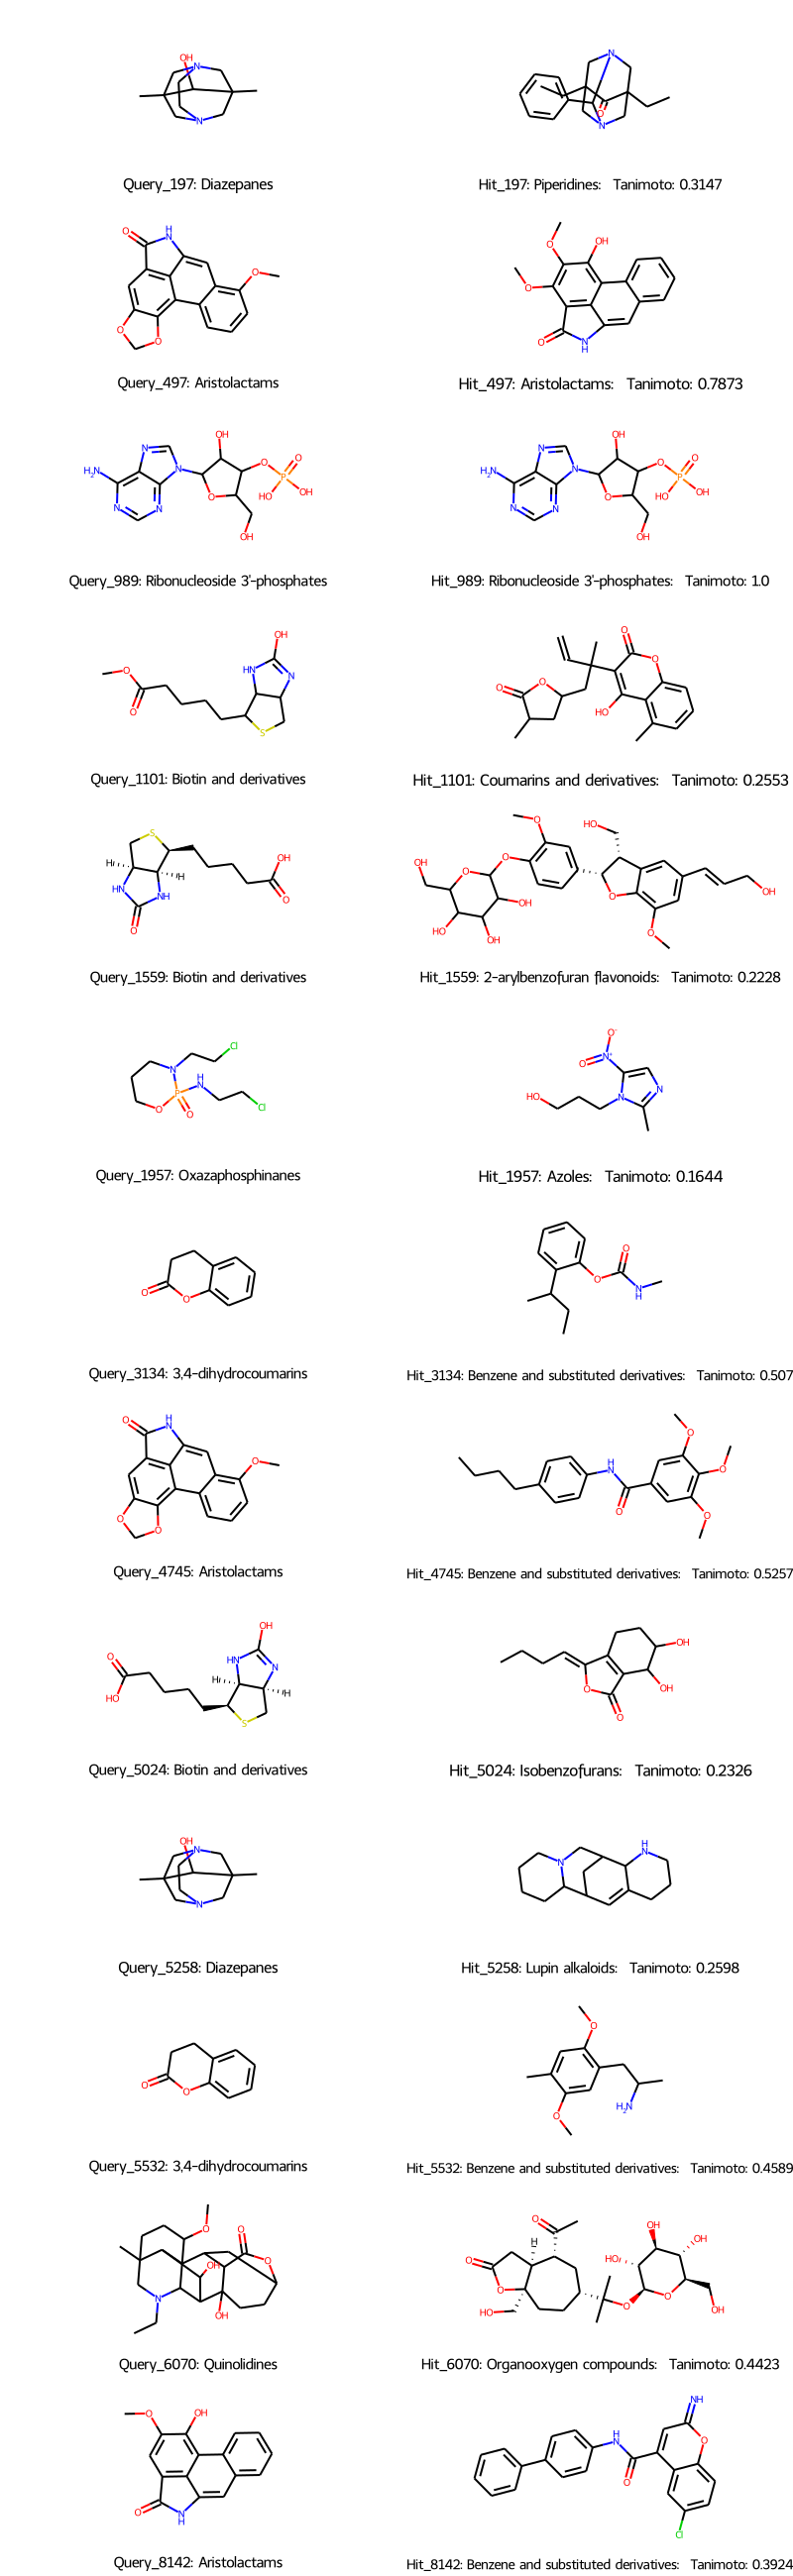

In [183]:
# sdl rare mols
sdl_rare_mols, sdl_rare_legends, sdl_rare_tanis = pick_hit_mols(hits_sdl,train_df,test_df,
          group=test_rare_classes,
                              return_tanimoto=True,filterby='cf_class')
Draw.MolsToGridImage(sdl_rare_mols,
                        molsPerRow=2, 
                        legends = sdl_rare_legends,
                        subImgSize=(400,200),
                                returnPNG=True)

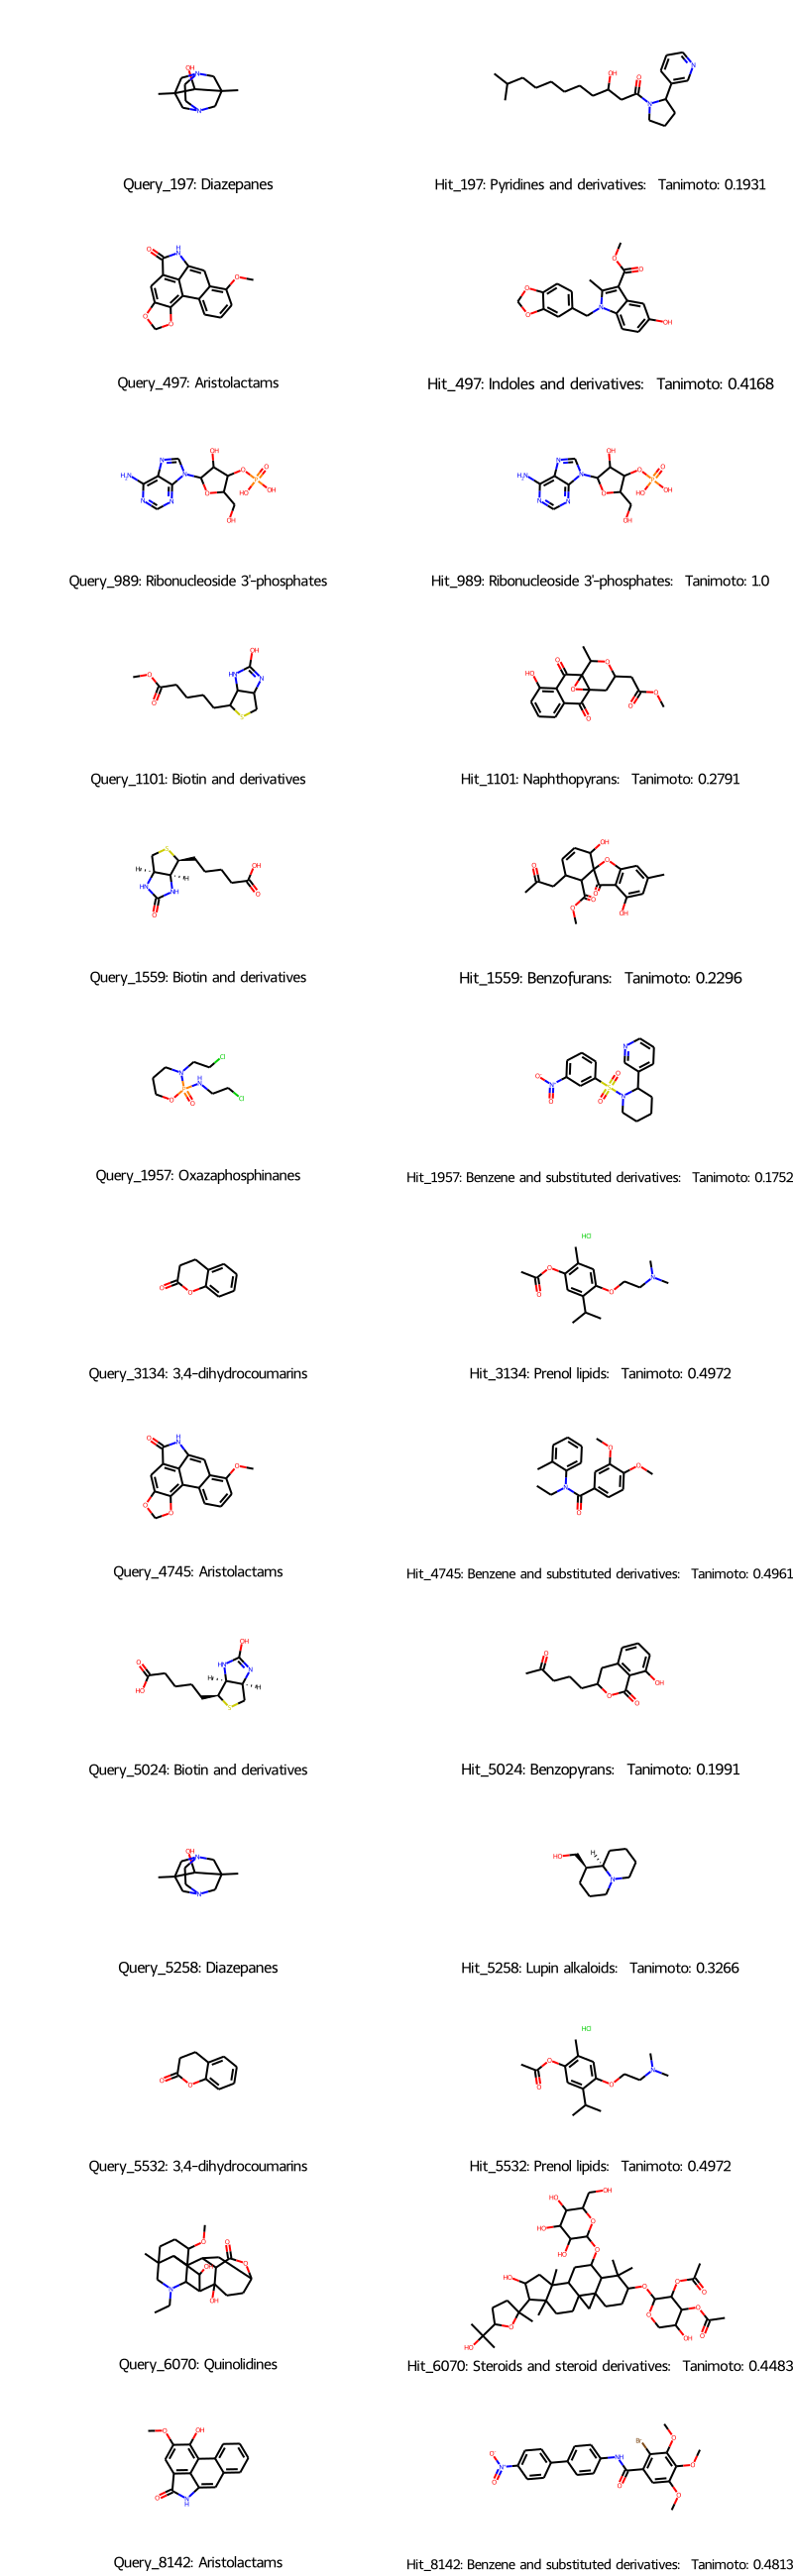

In [184]:
# cca rare mols
cca_rare_mols, cca_rare_legends, cca_rare_tanis = pick_hit_mols(hits_cca,train_df,test_df,
          group=test_rare_classes,filterby='cf_class',
                              return_tanimoto=True)
Draw.MolsToGridImage(cca_rare_mols,
                        molsPerRow=2, 
                        legends = cca_rare_legends,
                        subImgSize=(400,200),
                                returnPNG=True)

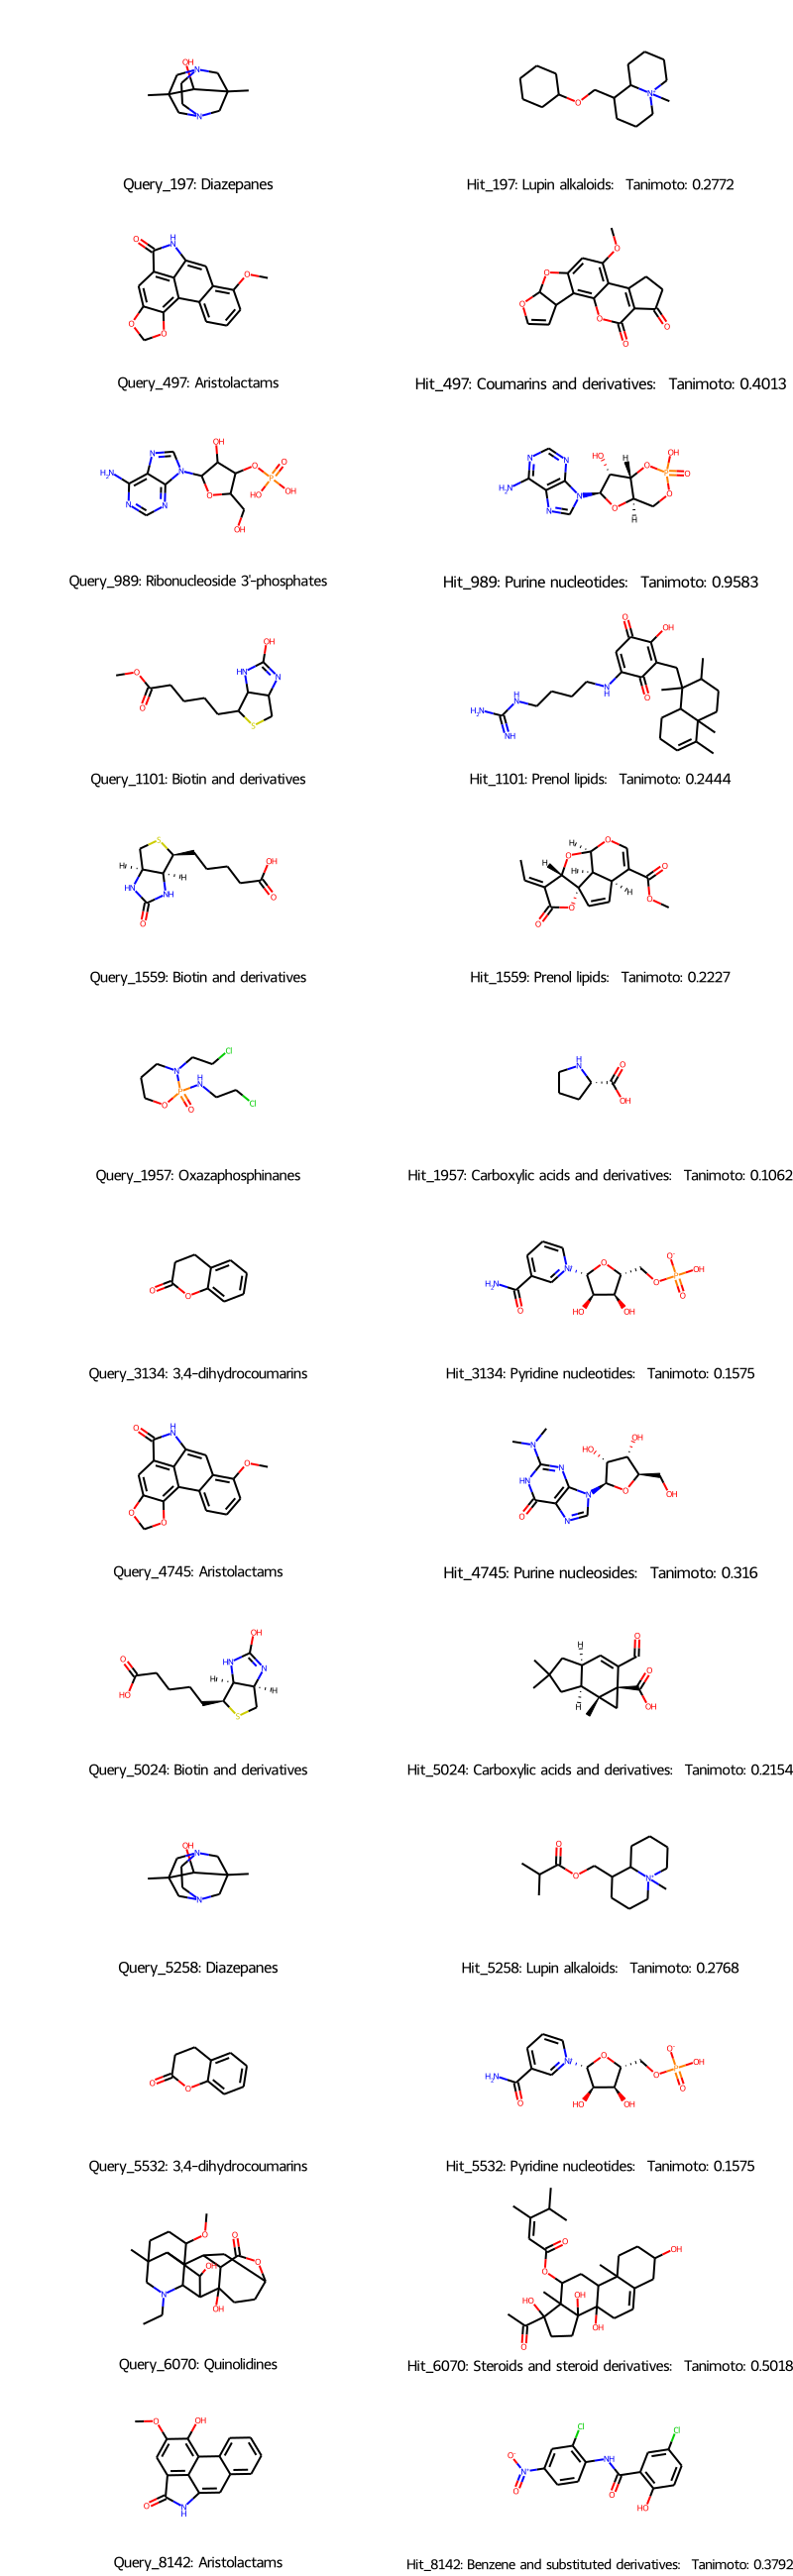

In [185]:
# dcca rare mols
dcca_rare_mols, dcca_rare_legends, dcca_rare_tanis = pick_hit_mols(hits_dcca,train_df,test_df,
          group=test_rare_classes,filterby='cf_class',
                              return_tanimoto=True)
Draw.MolsToGridImage(dcca_rare_mols,
                        molsPerRow=2, 
                        legends = dcca_rare_legends,
                        subImgSize=(400,200),
                                returnPNG=True)

In [144]:
#plot the distribution of the three top tanimotos from the three metrics
def plot_distribution(values, title,
                      savefig=False,
                      legends=None,xlab=None,
                    ylab=None,
                      palette = None,
                     fig_path=None
                     ):
    
    for i, val in enumerate(values):
        if palette:
            ax=sns.kdeplot(x=val, color=palette[i],shade=False)
            
        else:
            ax=sns.kdeplot(x=val,shade=True)
    
    plt.legend(labels=legends, loc='center left', fontsize=12)
    plt.xlabel(xlab, fontsize=15)
    plt.ylabel(ylab, fontsize=15)
    plt.title(label=title, fontsize=15)
    
    if savefig and fig_path:
        plt.savefig(fig_path,\
               transparent=False,bbox_inches = 'tight')
    plt.show()

In [19]:
tanis = [sdl_rare_tanis,cca_rare_tanis,dcca_rare_tanis]
legends = ['SDL', 'CCA','DCCA']
xlab, ylab = 'Tanimoto score', 'Density'
title = 'Tanimoto score for classes less or equal to 2'
fig_path = './rare_class_tanis.png'

plot_distribution(tanis, title,
                      legends=legends,xlab=xlab,
                    ylab=ylab,
                  palette = palette[0:3],
                     fig_path=fig_path,
                     savefig=True)

#### Investigate if the models will always return true hits if it is in the subject dataset(database)

In [26]:
# select inchikey14 occuring both in test(query) and train(subject) 
common_inchikeys =train_df.groupby('inchikey14').filter(lambda x : len(x)>=2)
common_inchikeys.shape

(24230, 14)

In [27]:
common_chi_list = [x for x in common_inchikeys['inchikey14']]

In [101]:
test_common_ichi= test_df.\
loc[test_df['inchikey14'].isin(common_chi_list)]
test_common_ichi.shape

test_common_list = [x for x in test_common_ichi['inchikey14']]#,k=10)# sample a few to draw structures

In [28]:
# sdl common mols
sdl_common_mols, sdl_common_legends, sdl_common_tanis = pick_hit_mols(hits_sdl,train_df,test_df,
          #group=test_common_list,
                              return_tanimoto=True)
# Draw.MolsToGridImage(sdl_common_mols,
#                         molsPerRow=2, 
#                         legends = sdl_common_legends,
#                         subImgSize=(400,200),
#                                 returnPNG=True)

In [29]:
len(sdl_common_tanis)

8290

In [121]:
# cca common mols
cca_common_mols, cca_common_legends, cca_common_tanis = pick_hit_mols(hits_cca,Models.train_df,Models.test_df,
          #group=test_common_list,
                              return_tanimoto=True)
# Draw.MolsToGridImage(cca_common_mols,
#                         molsPerRow=2, 
#                         legends = cca_common_legends,
#                         subImgSize=(400,200),
#                                 returnPNG=True)

In [122]:
# dcca common mols
dcca_common_mols, dcca_common_legends, dcca_common_tanis = pick_hit_mols(hits_dcca,Models.train_df,Models.test_df,
          #group=test_common_list,
                              return_tanimoto=True)
# Draw.MolsToGridImage(dcca_common_mols,
#                         molsPerRow=2, 
#                         legends = dcca_common_legends,
#                         subImgSize=(400,200),
#                                 returnPNG=True)

In [105]:
len(sdl_common_tanis)

2746

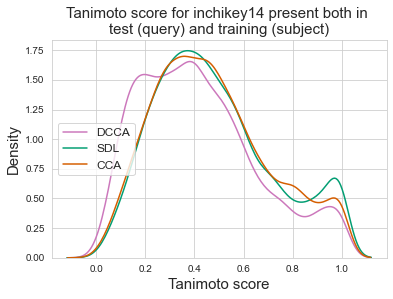

In [149]:
tanis = [dcca_common_tanis,sdl_common_tanis,cca_common_tanis]
legends = ['DCCA', 'SDL','CCA']
xlab, ylab = 'Tanimoto score', 'Density'
title = 'Tanimoto score for inchikey14 present both in \ntest (query) and training (subject)'
fig_path = './common_class_tanis.png'

plot_distribution(tanis, title,
                      legends=legends,xlab=xlab,
                    ylab=ylab,
                      palette = palette[0:3],
                     fig_path=fig_path,
                     savefig=True)

In [30]:
from sklearn.manifold import TSNE

In [31]:
# group queries based on tanimoto scores with their top hit
category = []
for tani in sdl_common_tanis:
    if tani <= 0.5:
        category.append('Low (tanimoto=<0.5)')
    elif 0.5 < tani < 0.8:
        category.append('Medium (0.5<tanimoto<0.8)')
    elif tani >= 0.8:
        category.append('High (tanimoto>=0.8)')
        
len(category)   

8290

In [32]:
category.count('Medium (0.5<tanimoto<0.8)')

2503

In [33]:
# create a column in the df with category; also append the tanis to be sure they were well categorised
test_df['category'] = category
test_df['tanimoto'] = sdl_common_tanis
test_df.tail()


# test_common_ichi['category'] = category
# test_common_ichi['tanimoto'] = sdl_common_tanis
# test_common_ichi.tail()
#no idea of pandas warnings; but if it works dont touch :)

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,cca_z1,cca_z2,dcca_z1,dcca_z2,sdl_z1,sdl_z2,category,tanimoto
35891,COc1cc2c(c3c1C(=O)C[C@@H](C)O3)CCO2,BCRRDBKZXSRMHL-SSDOTTSWSA-N,BCRRDBKZXSRMHL,spec_id35185,"[-14.430546402103886, 13.378277918251564, -15....","[17.235132217407227, 1.8385984897613525, 13.29...","[2.4208617, -4.1389537, -3.4290025, 1.7112641,...",Benzopyrans,"[-0.056657266028399364, 0.43876541362656396, -...","[-0.32730264184199753, 0.37407988426782524, -0...","[0.024896372, -0.12655973, 0.029115696, -0.061...","[0.10938725, -0.07197909, 0.0924918, 0.0741438...","[-0.22937623, -0.4021987, 0.06925637, -0.44390...","[-0.11675471, -0.23702133, 0.113411844, -0.457...",High (tanimoto>=0.8),0.9082
5764,CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N2Cc3c...,JSDRRTOADPPCHY-HSQYWUDLSA-N,JSDRRTOADPPCHY,spec_id5115,"[11.34721270242125, -6.88558385142898, -4.0925...","[0.0, 0.0, 24.464862823486328, 0.0, 0.0, 9.154...","[0.9236122, -4.62386, -2.596933, 5.1189394, 0....",Carboxylic acids and derivatives,"[-0.4340095609197095, 0.3542530302374649, -0.5...","[-0.5892114007684558, 0.42375161895298735, 0.0...","[0.03205085, -0.13752228, 0.015258305, -0.0088...","[0.1275516, -0.1338278, 0.08618868, 0.13127705...","[0.57393515, -0.63882744, 0.0070894733, -0.050...","[-0.71803665, -0.4941491, 0.11927539, -0.11566...",Low (tanimoto=<0.5),0.4734
40973,C[C@]12CC[C@@H](C([C@@H]1CC[C@@]3([C@@H]2C[C@H...,NPZAABKZLIBPQV-FDUYOZAUSA-N,NPZAABKZLIBPQV,spec_id40904,"[0.20953829972905935, -2.397303667870502, 3.33...","[0.0, 41.4199104309082, 16.17876434326172, 0.0...","[-1.9038436, -23.796093, -24.390234, -3.612248...",Prenol lipids,"[-0.024690969470621216, -2.1750219954123224, -...","[0.5498883212788304, -3.1084911242616724, -1.2...","[0.08230714, -0.46604016, -0.3599971, 0.117500...","[0.59320414, -0.25607413, 0.45178133, 0.092075...","[-0.8024368, 0.18174988, 0.20200147, 3.0600743...","[-1.2636597, 0.20879495, -0.3005826, 3.3488975...",High (tanimoto>=0.8),0.9985
8421,CC[C@H]([C@H]1O[C@@](CC)(C[C@@H]1C)[C@H]2CC[C@...,BBMULGJBVDDDNI-OWKLGTHSSA-N,BBMULGJBVDDDNI,spec_id7279,"[31.041507407508796, 28.324929542619458, -0.24...","[0.0, 8.848535537719727, 3.996480941772461, 0....","[0.49846756, -0.9150761, -4.2161984, -0.166028...",Prenol lipids,"[-0.09644515042259012, -0.7008327983320639, 0....","[-0.27528464702912786, -0.8262321892607873, 0....","[0.15398113, -0.11306002, -0.10519275, -0.1064...","[0.20611818, -0.07631008, 0.12546274, 0.083648...","[0.54687166, 0.29758218, 0.12577814, 0.1956073...","[1.328227, 0.045552254, 0.06082475, 0.69786966...",Low (tanimoto=<0.5),0.4110
19223,CCOc1ccc2[nH]c(=O)c(C(c3nnnn3C(C)(C)C)N3CCN(Cc...,NEHSMRMOOSXSBN-UHFFFAOYSA-N,NEHSMRMOOSXSBN,spec_id17312,"[5.7147400454528015, -3.8895424687663693, 10.8...","[0.0, 0.0, 22.354049682617188, 0.0, 0.0, 0.0, ...","[2.4906812, -4.114423, -2.6713428, 11.416074, ...",Quinolines and derivatives,"[-0.605453334837193, 0.5444996739730802, -0.96...","[-0.5629429070354108, 1.2410010423298803, -0.0...","[-0.010662608, -0.16331482, 0.03475984, -0.031...","[0.12629193, -0.10263409, 0.08373776, 0.108128...","[0.08322346, -0.7630259, 0.09471382, -0.248445...","[-0.20093656, -0.84802246, 0.39735553, -0.4102...",Medium (0.5<tanimoto<0.8),0.5388


In [34]:
x = np.array([i for i in test_df['sdl_z1']])

y = np.array([i for i in test_df['sdl_z2']])

In [35]:
tsne = TSNE(n_components=2, 
            verbose=0, 
            perplexity=10, # assuming these is related to neighbours
            n_iter=1000,
           init = 'pca',
           learning_rate = 'auto'
           )

x_transformed = tsne.fit_transform(x)
y_transformed = tsne.fit_transform(y)


C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


No handles with labels found to put in legend.


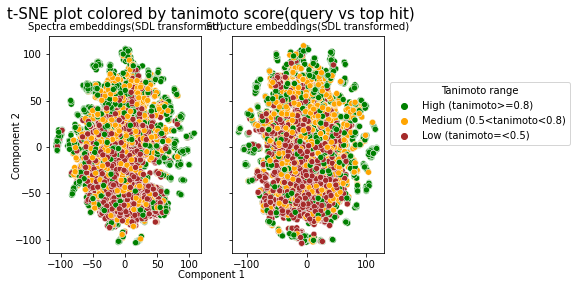

In [61]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sns.scatterplot(x=x_transformed[:,0],
           y=x_transformed[:,1], hue = category, 
                palette = ['green', 'orange','brown'],
                ax=ax1, legend=False)


sns.scatterplot(x=y_transformed[:,0],
           y=y_transformed[:,1], hue = category,
                palette = ['green', 'orange','brown'],
                ax=ax2)
f.suptitle('t-SNE plot colored by tanimoto score(query vs top hit)', fontsize=15)
ax1.set_title('Spectra embeddings(SDL transformed)', fontsize=10)
ax2.set_title('Structure embeddings(SDL transformed)', fontsize=10)
#plt.legend(labels=category, loc=(1.04, 0.5))
#ax1.set_ylabel('PC 2', fontsize=15)
f.text(0.5, 0.04, 'Component 1', ha='center')
f.text(0.04, 0.5, 'Component 2', va='center', rotation='vertical')
handles, labels = ax2.get_legend_handles_labels()

#ax1.legend(handles, labels, loc= (1.17, 0.5)) # hiding behind ax2 :)
ax2.legend(handles, labels, loc= (1.04, 0.5), title ='Tanimoto range')
leg = ax1.legend()
leg.remove()
plt.show()

#### Investigate which molecules are enriched in the high Tanimoto regions

In [55]:
# select classes under each category
high_class = test_df.loc[test_df['category'] == 'High (tanimoto>=0.8)']
medium_class = test_df.loc[test_df['category'] == 'Medium (0.5<tanimoto<0.8)']
low_class = test_df.loc[test_df['category'] == 'Low (tanimoto=<0.5)']
print(len(high_class),len(medium_class),len(low_class))

2840 2503 2947


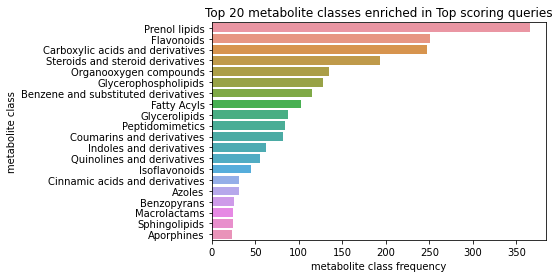

In [56]:
#check which classes are highly represented
high_class_counts =high_class['cf_class'].value_counts().\
rename_axis('cf_class').reset_index(name='counts')

ax=sns.barplot(data=high_class_counts[:20], x='counts', y='cf_class')
ax.set(xlabel='metabolite class frequency', \
       ylabel='metabolite class',
      title='Top 20 metabolite classes enriched in Top scoring queries')
plt.show()

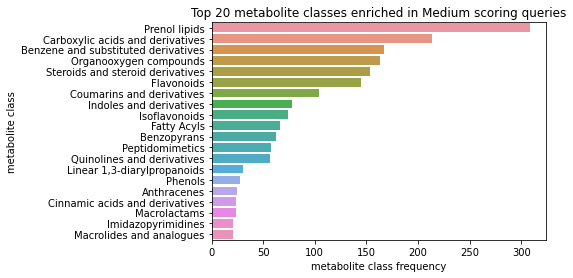

In [57]:
# medium class
medium_class_counts =medium_class['cf_class'].value_counts().\
rename_axis('cf_class').reset_index(name='counts')

ax=sns.barplot(data=medium_class_counts[:20], x='counts', y='cf_class')
ax.set(xlabel='metabolite class frequency', \
       ylabel='metabolite class',
      title='Top 20 metabolite classes enriched in Medium scoring queries')
plt.show()

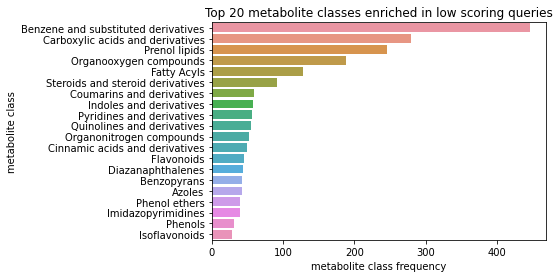

In [58]:

#check which classes are highly represented
low_class_counts =low_class['cf_class'].value_counts().\
rename_axis('cf_class').reset_index(name='counts')

ax=sns.barplot(data=low_class_counts[:20], x='counts', y='cf_class')
ax.set(xlabel='metabolite class frequency', \
       ylabel='metabolite class',
      title='Top 20 metabolite classes enriched in low scoring queries')
plt.show()

In [79]:

yes_no = []
for score in test_df['category']:
    if score == 'High (tanimoto>=0.8)':
        yes_no.append('yes')
    else:
         yes_no.append('no')
test_df['group'] = [x for x in yes_no] 

In [121]:
table_df = test_df[['cf_class', 'group']]
table_df.shape

(8290, 2)

### Fisher_exact test

This follows scipy.stats.fisher_exact test [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html)

In [175]:
#creat contigency table for all classes
levels = [x for x in table_df['group']]
cf_class = [x for x in table_df['cf_class']]

(xclass, xlevels),count = crosstab(cf_class, levels)
count.shape

(250, 2)

In [203]:
count[:5] #column1 == success(high score),column2 == no success(not high score)

array([[ 2,  1],
       [16,  2],
       [ 2,  0],
       [ 3,  1],
       [ 1,  0]])

In [211]:
# calculate fisher_eaxct test
pval = []
M = count.sum() 
for i in range(len(count)):
    x = count[i][0] # success for one class 
    n = count[i].sum() # total for one class
    n_x = n-x # no success for one class
    N = count[:,0].sum() #success for all classes
    N_x = N - x # total success minus x

    table = [[x, n_x], [N_x, (M - (n + N) + x)]]
    ods, p = fisher_exact(table) # two-sided ?
    pval.append(p)


In [212]:
df = {'cf_class':[x for x in xclass],
     'pval':[x for x in pval]}
df = pd.DataFrame(data=df)
df = df.sort_values('pval')
df.head()

,cf_class,pval
99,Glycerophospholipids,3.954802e-50
98,Glycerolipids,3.381735e-34
28,Benzene and substituted derivatives,2.337701e-31
249,nan,3.728228e-26
90,Flavonoids,1.804167e-23


#### Never mind the codes below; you have reached the end of important codes

In [310]:
#random drawing for top 5 hits

# #randomly pick a query
# keys = random.sample(test_cca_corr_tanimotos.keys(),5)
# sample_dict = {key: test_cca_corr_tanimotos[key] for key in keys}

# #draw select top 5 hits
# all_mols = []
# #scores = []
# mol_classes = []
# #os.chdir('../compounds')
# for query_index, values in tqdm(sample_dict.items()):
#     top_hits = np.sort(values)[:5]
#     tanimotos = []
    
#     #draw the query
    
#     query_smile= val_df['smiles'].iloc[query_index]
#     query_class = val_df['cf_class'].iloc[query_index]
#     if type(query_class) == float:
#         query_class = 'NAN'
#         classes = [f'Query:\t{query_class}',]
#     classes = [f'QUERY:\t{query_class}',]
#     query = Chem.MolFromSmiles(query_smile)
#     #Draw.MolToFile(query, f"dcca_max_corr_query_{query_index}_{query_class}.png")
#     #Draw.MolsToGridImage(query)
#     #draw top 5 hits
#     subjects = [query,]
#     for hit_index, hit in enumerate(top_hits):
#         subject_index = values.index(hit)
#         subject_smile = train_df['smiles'].iloc[subject_index]
        
        
#         subject = Chem.MolFromSmiles(subject_smile)
#         subjects.append(subject)
#         #Draw.MolToFile(subject, f"dcca_max_corr_query_{query_index}_hit_{hit_index}_{subject_class}.png")
#         cl = train_df['cf_class'].iloc[subject_index]
#         if type(cl) == float:
#             cl = 'NAN'
#             subject_class = f'\tHit_{hit_index}\t{cl}:\nTanimoto:\t{tanimoto(query_smile,subject_smile)}'
#             classes.append(subject_class)
#         else:
#             subject_class = f'\tHit_{hit_index}\t{cl}:\nTanimoto:\t{tanimoto(query_smile,subject_smile)}'
#             classes.append(subject_class)
#         #check tanimotos for the random selections
#         tanimotos.append(tanimoto(query_smile,subject_smile))
#    # scores.append([(query_index,query_class),tanimotos])
#     all_mols.append(subjects)
#     mol_classes.append(classes)


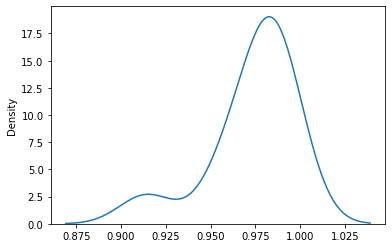

In [312]:
ax=sns.kdeplot(x=corr,shade=False)

In [ ]:
for key, values in sample_dict.items():
    print(key,max(values))
    print(np.sort(values)[::-1][0:5])